# Point Multiplication in Elliptic Curve Diffie-Hellman Key Exchange
## Radix-2 Windowing-Based Scalar Multiplication in Curve K163

In elliptic curve cryptography, point multiplication is a fundamental operation used in various cryptographic protocols such as Elliptic Curve Diffie-Hellman (ECDH) key exchange and Elliptic Curve Digital Signature Algorithm (ECDSA).

One approach to performing point multiplication is the radix-2 windowing-based scalar multiplication algorithm. This algorithm involves breaking the scalar into several bit-windows and performing precomputations on the points corresponding to each bit-window. Then, during the actual multiplication, the algorithm uses these precomputed points and a sliding window to efficiently compute the final result.

This implementation is demonstrated on curve K163, a popular elliptic curve used in various cryptographic protocols.



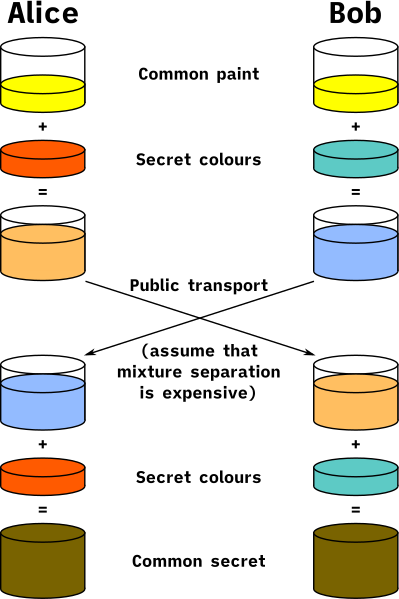

In [2]:
from pynq import Overlay
ol = Overlay('/home/xilinx/pynq/radix2w/design.bit')
from collections import namedtuple

## Creating an alias for the IP

In [3]:
my_ip = ol.Radix2wECC_0

## Checking the register map of the IP

the registers that we need to write values to:

* CTRL - the control register
* k_1 - the lower 32-bits of the start address for the memory range the IP will access to write get the value of the scalar
* x_o_1 - the lower 32-bits of the start address for the memory range the IP will access to write the value of the x coordinate 
* y_o_1 - the lower 32-bits of the start address for the memory range the IP will access to write the value of the y coordinate

In [4]:
my_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  k_1 = Register(k=write-only),
  k_2 = Register(k=write-only),
  x_o_1 = Register(x_o=write-only),
  x_o_2 = Register(x_o=write-only),
  y_o_1 = Register(y_o=write-only),
  y_o_2 = Register(y_o=write-only)
}

## Allocating some memory

The start address for this memory will be passed to the IP. The IP will read data from this memory and write results back to the x and y coordinate memory locations. 

We can initialise the memory 

In [5]:
from pynq import allocate
import numpy as np 
import time
k_buffer = allocate(shape=(6,), dtype=np.uint32)
x_buffer = allocate(shape=(6,),dtype=np.uint32)
y_buffer = allocate(shape=(6,),dtype=np.uint32)
x = np.array([ 0x5c94eee8, 0xde4e6d5e, 0xaa07d793, 0x7bbc11ac, 0xfe13c053, 0x00000002], dtype=np.uint32)
r2 = np.array([0x0FFF8000, 0xF0003E00, 0xE0001FFF, 0xFFF00FFF, 0x0FFE0FFF, 0x00000002], dtype=np.uint32)
y = np.array([0xccdaa3d9, 0x0536d538, 0x321f2e80, 0x5d38ff58, 0x89070fb0, 0x00000002], dtype=np.uint32)
two_key = np.array([0x00000002, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
four_key = np.array([0x00000004, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
six_key = np.array([0x00000006, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
eight_key = np.array([0x00000008, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
nine_key = np.array([0x00000009, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000],dtype=np.uint32)
B_key = np.array([0x99F8A5EE, 0xA2E0CC0D,0x00020108, 0x00000000, 0x00000000,0x4],dtype = np.uint32)
B_x = np.array([0xE8343E36, 0xD4994637, 0xA0991168, 0x86A2D57E, 0xF0EBA162, 0x03],dtype = np.uint32)
B_y = np.array([0x797324F1, 0xB11C5C0C, 0xA2CDD545, 0x71A0094F, 0xD51FBC6C, 0x0],dtype = np.uint32)

np.copyto(x_buffer, x)
np.copyto(y_buffer, y)

In [6]:
print("py_buffer physical address {}".format(hex(k_buffer.physical_address)))

py_buffer physical address 0x1686a000


## Configuring the IP

Writing the values of the memory address of scalar k, coordinate x, and coordinate y


In [7]:
my_ip.register_map.k_1 = k_buffer.physical_address
my_ip.register_map.x_o_1 = x_buffer.physical_address
my_ip.register_map.y_o_1 = y_buffer.physical_address

## Start the IP

In [8]:
np.copyto(k_buffer,two_key)
start = time.perf_counter()

my_ip.register_map.CTRL.AP_START = 1

# Wait for IP to finish
while not my_ip.register_map.CTRL.AP_DONE:
    pass
hex_string = "k = "
for i in range(len(k_buffer)-1, -1, -1):
    hex_string += "{:08X}".format(k_buffer[i])
print(hex_string)
hex_string = "x = "
for i in range(len(x_buffer)-1, -1, -1):
    hex_string += "{:08X}".format(x_buffer[i])
print(hex_string)
hex_string = "y = "
for i in range(len(y_buffer)-1, -1, -1):
    hex_string += "{:08X}".format(y_buffer[i])
print(hex_string)
stop = time.perf_counter()
extime = (stop - start) * 1e6
print(extime, "microseconds")   

k = 000000000000000000000000000000000000000000000002
x = 00000000CB5CA2738FE300AACFB00B42A77B828D8A5C41EB
y = 0000000229C79E9AB85F90ACD3D5FA3A696664515EFEFA6B
24456.113999804074 microseconds


## Check the IP completed

If we start the IP once, when the IP completes an iteration DONE will go high **once**. While the IP is working, AP_IDLE will be 0. 


In [9]:
print(my_ip.register_map.CTRL.AP_DONE)
print(hex(my_ip.register_map.k_1.address))

0
0x10


## Check the contents of the memory

In [10]:
def point_multiplication(key):
    np.copyto(k_buffer, key)
    np.copyto(x_buffer, x)
    np.copyto(y_buffer, y)
    my_ip.register_map.CTRL.AP_START = 1

# Wait for IP to finish
    while not my_ip.register_map.CTRL.AP_DONE:
        pass
    hex_string = "k = "
    print("k =",k_buffer[0])
    hex_string = "x = "
    for i in range(len(x_buffer)-1, -1, -1):
        hex_string += "{:08X}".format(x_buffer[i])
    print(hex_string)
    hex_string = "y = "
    for i in range(len(y_buffer)-1, -1, -1):
        hex_string += "{:08X}".format(y_buffer[i])
    print(hex_string)
point_multiplication(two_key)
point_multiplication(four_key)
point_multiplication(six_key)
point_multiplication(eight_key)

k = 2
x = 00000000CB5CA2738FE300AACFB00B42A77B828D8A5C41EB
y = 0000000229C79E9AB85F90ACD3D5FA3A696664515EFEFA6B
k = 4
x = 00000000BA8C7E6E2523EF94CBC1E56FACFEDE24F3F91578
y = 0000000510F96CBC41CF3BDFA0157E9E8FEE2C605791DB0D
k = 6
x = 0000000765470BC65E9AB8C40B297C983B1000BCF021426E
y = 00000000A58BA7C589659F870A0CB121F76D61122D8741B6
k = 8
x = 00000003A11E19CC4C0B15CD4C7D5A5CF2D5A8C383287DA8
y = 0000000204041306C461A237C8E5D1644D0ACA7D738A1257


For referencing Point Multiplication values, the following link can be visited: http://point-at-infinity.org/ecc/nisttv

#  Elliptic Curve Diffie-Hellman (ECDH) key exchange protocol using a scalar multiplication IP
### "Python Implementation of Elliptic Curve Diffie-Hellman Key Exchange using Scalar Multiplication IP"
The code calculates the public keys, exchanges them, and validates the shared secret.

In [11]:
def ecdh(a_key,b_key):
    # Alice's variables
    alice_pb_x = np.empty(6, dtype=np.uint32)
    alice_pb_y = np.empty(6, dtype=np.uint32)
    shared_alice_x = np.empty(6, dtype=np.uint32)
    shared_alice_y = np.empty(6, dtype=np.uint32)

    # Bob's variables
    bob_pb_x = np.empty(6, dtype=np.uint32)
    bob_pb_y = np.empty(6, dtype=np.uint32)
    shared_bob_x = np.empty(6, dtype=np.uint32)
    shared_bob_y = np.empty(6, dtype=np.uint32)
    #alice public key generation
    k_buffer=a_key
    x_buffer=x
    y_buffer = y
    my_ip.register_map.CTRL.AP_START =1
    np.copyto(alice_pb_x, x_buffer)
    np.copyto(alice_pb_y, y_buffer)
    while not my_ip.register_map.CTRL.AP_DONE:
        pass
    #bob public key generation
    k_buffer=b_key
    x_buffer=x
    y_buffer = y
    my_ip.register_map.CTRL.AP_START =1
    np.copyto(bob_pb_x, x_buffer)
    np.copyto(bob_pb_y, y_buffer)
    while not my_ip.register_map.CTRL.AP_DONE:
        pass
    # exchange alice
    k_buffer=a_key
    x_buffer= bob_pb_x
    y_buffer = bob_pb_y
    my_ip.register_map.CTRL.AP_START =1
    np.copyto(shared_alice_x, x_buffer)
    np.copyto(shared_alice_y, y_buffer)
    while not my_ip.register_map.CTRL.AP_DONE:
        pass
    # exchange bob
    k_buffer=b_key
    x_buffer= alice_pb_x
    y_buffer = alice_pb_y
    my_ip.register_map.CTRL.AP_START =1
    np.copyto(shared_bob_x, x_buffer)
    np.copyto(shared_bob_y, y_buffer)
    while not my_ip.register_map.CTRL.AP_DONE:
        pass
    if(np.all(shared_bob_x==shared_alice_x) and np.all(shared_bob_y==shared_alice_y)):
        print("Key exchange successful")
    else:
        print("Key exchange failed")
ecdh(A_key, B_key)

NameError: name 'A_key' is not defined